In [221]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from os import listdir
from os.path import isfile, join
from PIL import Image
import pickle
from tensorflow.keras import backend as K

In [222]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5
DATASET_PATH = f'../../../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

def load_data():
    featuresNumber = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 

    def get_tuple_dataset(row):
        X = row[0 : featuresNumber].astype('float32')
        Y = row[featuresNumber: ].astype('float32') # opt_band is in target
        return X, Y

    df = pd.read_csv(DATASET_PATH)
    train_dataset_df = df.sample(frac=0.8)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    train_dataset = list(map(get_tuple_dataset, train_dataset_df.to_numpy()))
    val_dataset = list(map(get_tuple_dataset, val_dataset_df.to_numpy()))
    test_dataset = list(map(get_tuple_dataset, test_dataset_df.to_numpy()))
    return train_dataset, val_dataset, test_dataset

In [223]:
train_dataset, val_dataset, test_dataset = load_data()

In [224]:
def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

def processDataToImage(graphInput):
    adj = getGraph(graphInput)
    w, h = NUMBER_NODES, NUMBER_NODES
    data = np.zeros((h, w), dtype=np.uint8)
    for i in range(len(adj)):
        for j in range(len(adj)):
            if adj[i, j] == 1:
                data[i, j] = 255.0
    img = Image.fromarray(data, 'L')
    resized = img.resize((32, 32), Image.NEAREST)
    image = np.array(resized, dtype=np.float64)
    image = np.reshape(image, (32, 32, 1))
    return image

def processImageOutput(graphInput, nodelist):
    adj = getGraph(graphInput)
    Graph = nx.Graph(adj)
    adj = nx.adjacency_matrix(Graph, nodelist=nodelist)

    w, h = NUMBER_NODES, NUMBER_NODES
    data = np.zeros((h, w), dtype=np.uint8)
    for i in range(adj.shape[0]):
        for j in range(adj.shape[0]):
            if adj[i, j] == 1:
                data[i, j] = 255.0
    img = Image.fromarray(data, 'L')
    resized = img.resize((32, 32), Image.NEAREST)
    image = np.array(resized, dtype=np.float64)
    image = np.reshape(image, (32, 32, 1))
    return image

In [225]:
def getData_2(dataset):
    train_x = []
    train_output = []
    for graphInput, target in dataset:
        nodelist = target[1 : ]
        x_image = processDataToImage(graphInput)
        train_x.append(x_image)
        y_image = processImageOutput(graphInput, nodelist)
        train_output.append(y_image)
    return np.array(train_x), np.array(train_output)

In [226]:
train_x, train_y = getData_2(train_dataset)
val_x, val_y= getData_2(val_dataset)
test_x, test_y = getData_2(test_dataset)

print(train_x.shape)
print(train_y.shape)

(835, 32, 32, 1)
(835, 32, 32, 1)


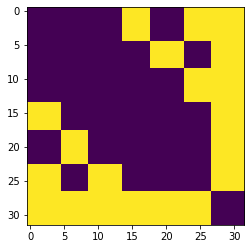

<Figure size 432x288 with 0 Axes>

In [227]:
plt.imshow(train_x[0])
plt.show()
plt.clf()


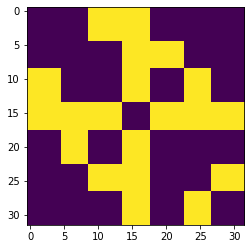

In [228]:
plt.imshow(train_y[0])

In [229]:
examples = train_x[0:2]
examples_y = train_y[0:2]
print(examples.shape)

rescaling = layers.Rescaling(1./255)
pred = layers.Conv2D(1, 3, padding='same', activation='relu', input_shape=(32, 32))(rescaling(examples))
print(pred.shape)

print(examples[0].dtype)
print(pred[0].dtype)
print(examples_y[0].dtype)

(2, 32, 32, 1)
(2, 32, 32, 1)
float64
<dtype: 'float32'>
float64


In [230]:
def frobeniusLoss(y_true, y_pred):
  error = y_true - y_pred
  size = tf.size(error)
  return tf.norm(error, ord='fro',axis=(0,1)) / tf.cast(size, tf.float32)

In [231]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(256, 256, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

initializer = tf.random_normal_initializer(0., 0.02)

model = tf.keras.models.Sequential([
  # data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Conv2D(8, 6, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Conv2D(4, 12, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Conv2D(2, 24, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Conv2D(1, 48, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='relu'),
  # layers.Conv2D(1, 3, padding='same', activation='relu'),
  # layers.Conv2DTranspose(1, 2, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  # layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  # layers.Conv2DTranspose(1, 8, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  # layers.Conv2DTranspose(1, 16, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  # layers.Conv2DTranspose(1, 32, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
])

model.compile(optimizer='adam',
              loss=frobeniusLoss,
              # loss='mse',
              metrics=['accuracy'])

history = model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=256,
)

Epoch 1/256
27/27 [==============================] - 34s 1s/step - loss: 0.1617 - accuracy: 0.5173 - val_loss: 0.1623 - val_accuracy: 0.0000e+00
Epoch 2/256
27/27 [==============================] - 33s 1s/step - loss: 0.1266 - accuracy: 0.0000e+00 - val_loss: 0.1186 - val_accuracy: 0.0000e+00
Epoch 3/256
27/27 [==============================] - 33s 1s/step - loss: 0.1139 - accuracy: 0.0020 - val_loss: 0.1166 - val_accuracy: 0.0130
Epoch 4/256
27/27 [==============================] - 32s 1s/step - loss: 0.1124 - accuracy: 0.0248 - val_loss: 0.1152 - val_accuracy: 0.0255
Epoch 5/256
27/27 [==============================] - 32s 1s/step - loss: 0.1106 - accuracy: 0.0395 - val_loss: 0.1133 - val_accuracy: 0.0520
Epoch 6/256
27/27 [==============================] - 35s 1s/step - loss: 0.1084 - accuracy: 0.0799 - val_loss: 0.1109 - val_accuracy: 0.1106
Epoch 7/256
27/27 [==============================] - 34s 1s/step - loss: 0.1066 - accuracy: 0.1105 - val_loss: 0.1100 - val_accuracy: 0.1315
E

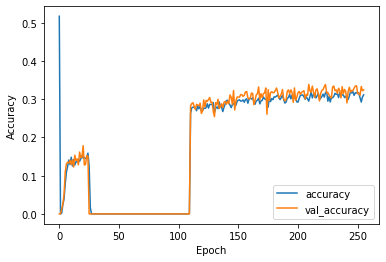

In [232]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

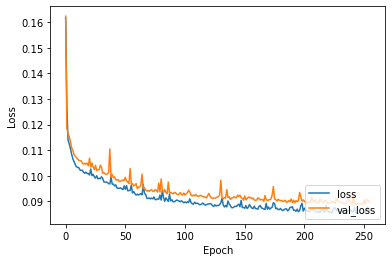

In [233]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [234]:
# test = np.array([test_images[0]])
pred = model.predict(test_x)
true = test_y
# print(pred)
print("Pred")
print(pred.shape)
print("True")
print(true.shape)

Pred
(63, 32, 32, 1)
True
(63, 32, 32, 1)


Image processed


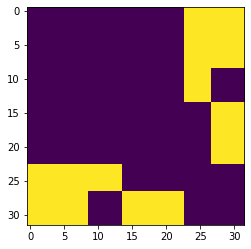

<Figure size 432x288 with 0 Axes>

In [235]:
print("Image processed")
plt.imshow(test_x[1])
plt.show()
plt.clf()

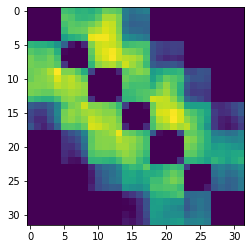

<Figure size 432x288 with 0 Axes>

In [236]:
# print(pred[0] * 255)
plt.imshow(pred[1])
plt.show()
plt.clf()

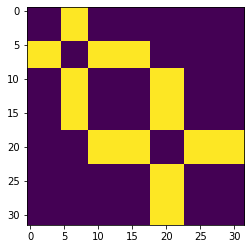

In [237]:
plt.imshow(true[1])
plt.show()

Entry 20


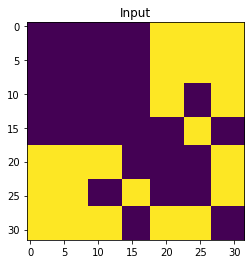

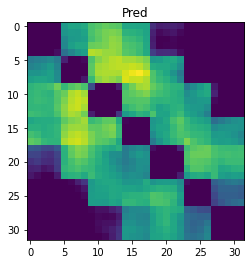

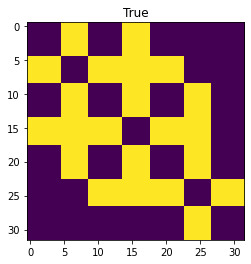

Entry 21


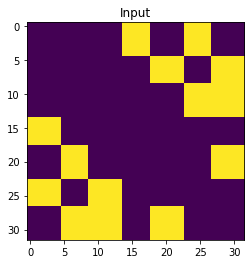

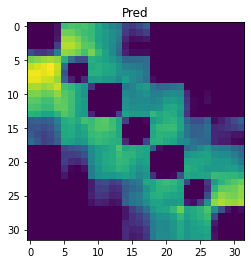

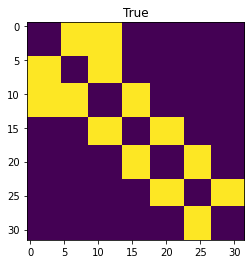

Entry 22


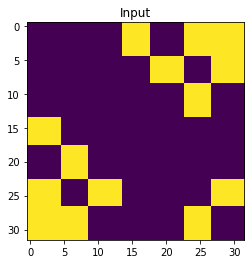

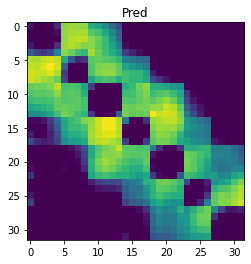

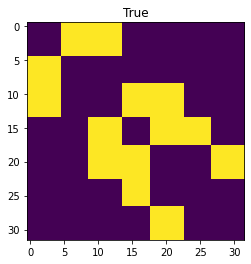

In [239]:
for i in range(20, 23):
  print("Entry", i)
  plt.title("Input")
  plt.imshow(test_x[i])
  plt.show()

  plt.title("Pred")
  plt.imshow(pred[i])
  plt.show()

  plt.title("True")
  plt.imshow(test_y[i])
  plt.show()